In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm, chi2

In [2]:
ALPHA = 0.05

Read the data

In [3]:
DatOriginal = pd.read_csv("DatasetsMedicalResearch/Prognosis for women with breast cancer.dat", sep="\s+")
DatOriginal = DatOriginal.rename({'time':'Time'}, axis=1)
DatOriginal['Censored'] = (DatOriginal['status']-1)*(-1)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_6247/1354729485.py:1: SyntaxWarning: invalid escape sequence '\s'
  DatOriginal = pd.read_csv("DatasetsMedicalResearch/Prognosis for women with breast cancer.dat", sep="\s+")


Split the data for each group

In [4]:
DatOriginalNegative = DatOriginal[DatOriginal['stain']==1]
DatOriginalNegative = DatOriginalNegative[['Time', 'Censored']]

In [5]:
DatOriginalPositive = DatOriginal[DatOriginal['stain']==2]
DatOriginalPositive = DatOriginalPositive[['Time', 'Censored']]

---

Function to create the life-table

In [6]:
def CreateLifeTable(data):

    datalifetable = pd.DataFrame(
        {
            'tj': np.unique([0] + data.loc[data['Censored']==0, 'Time'].sort_values().to_list())
        }
    )

    datalifetable = datalifetable.reset_index(drop=True)

    datalifetable['tj+1'] = datalifetable['tj'].to_list()[1:] + [np.inf]

    n_list, d_list, c_list = [], [], []

    for j in range(len(datalifetable)):
        
        if j==0:
            n = len(data)
        else:
            n = n-d-c

        d = sum(data.loc[data['Censored']==0, 'Time'] == datalifetable.loc[j]['tj'])
        c = sum(
                (data.loc[data['Censored']==1, 'Time'] >= datalifetable.loc[j]['tj']) 
                & (data.loc[data['Censored']==1, 'Time'] < datalifetable.loc[j]['tj+1'])
            )

        n_list.append(n)
        d_list.append(d)
        c_list.append(c)

    datalifetable['nj'] = n_list
    datalifetable['dj'] = d_list
    datalifetable['cj'] = c_list

    return datalifetable

Function to create the life-table of the combined groups

In [7]:
def CreateLifeTableCombined(data, datagroup1, datagroup2):

    datalifetablecombined = pd.DataFrame(
        {
            'tj': np.unique([0] + data.loc[data['Censored']==0, 'Time'].sort_values().to_list())
        }
    )

    datalifetablecombined = datalifetablecombined.reset_index(drop=True)

    datalifetablecombined['tj+1'] = datalifetablecombined['tj'].to_list()[1:] + [np.inf]

    n1_list, d1_list, c1_list = [], [], []
    n2_list, d2_list, c2_list = [], [], []

    for j in range(len(datalifetablecombined)):
        
        if j==0:
            n1 = len(datagroup1)
            n2 = len(datagroup2)
        else:
            n1 = n1-d1-c1
            n2 = n2-d2-c2

        d1 = sum(data.loc[(data['Censored']==0) & (data['stain']==1), 'Time'] == datalifetablecombined.loc[j]['tj'])
        c1 = sum(
                (data.loc[(data['Censored']==1) & (data['stain']==1), 'Time'] >= datalifetablecombined.loc[j]['tj']) 
                & (data.loc[(data['Censored']==1) & (data['stain']==1), 'Time'] < datalifetablecombined.loc[j]['tj+1'])
            )

        d2 = sum(data.loc[(data['Censored']==0) & (data['stain']==2), 'Time'] == datalifetablecombined.loc[j]['tj'])
        c2 = sum(
                (data.loc[(data['Censored']==1) & (data['stain']==2), 'Time'] >= datalifetablecombined.loc[j]['tj']) 
                & (data.loc[(data['Censored']==1) & (data['stain']==2), 'Time'] < datalifetablecombined.loc[j]['tj+1'])
            )

        n1_list.append(n1)
        d1_list.append(d1)

        n2_list.append(n2)
        d2_list.append(d2)

    datalifetablecombined['n1j'] = n1_list
    datalifetablecombined['d1j'] = d1_list

    datalifetablecombined['n2j'] = n2_list
    datalifetablecombined['d2j'] = d2_list

    datalifetablecombined['nj'] = datalifetablecombined['n1j'] + datalifetablecombined['n2j']
    datalifetablecombined['dj'] = datalifetablecombined['d1j'] + datalifetablecombined['d2j']

    datalifetablecombined['e1j'] = datalifetablecombined['n1j'] * datalifetablecombined['dj'] / datalifetablecombined['nj']
    datalifetablecombined['v1j'] = datalifetablecombined['n1j'] * datalifetablecombined['n2j'] * datalifetablecombined['dj'] * (datalifetablecombined['nj'] - datalifetablecombined['dj']) / (datalifetablecombined['nj']**2 * (datalifetablecombined['nj']-1))

    return datalifetablecombined

Function to calculate the survivor function, cumulative hazard function, and hazard function using the Kaplan-Meier approach

In [8]:
def KaplanMeier(datalifetable):
    datakm = datalifetable.copy()

    # Estimate survivor function, cumulative hazard function and hazard function
    datakm['Survivor'] = np.cumprod((datakm['nj'] - datakm['dj']) / datakm['nj'])
    datakm['CumHazard'] = -np.log(datakm['Survivor'])
    datakm['Hazard'] = datakm['dj'] / (datakm['nj'] * (datakm['tj+1'] - datakm['tj']))

    # Estimate standard deviation of the cumulative hazard function, and survivor function
    datakm['StdCumHazard'] = np.sqrt(np.cumsum(datakm['dj'] / (datakm['nj'] * (datakm['nj'] - datakm['dj']))))
    datakm['StdSurvivor'] = datakm['Survivor'] * datakm['StdCumHazard']

    return datakm

Function to compute confidence intervals for the cumulative hazard function, and the survivor function

In [9]:
def GetConfidenceInterval(datasurvivor, alpha):

    datasurvivor['LowerLogCumHazar'] = norm.ppf(alpha/2, np.log(datasurvivor['CumHazard']), datasurvivor['StdCumHazard'] / datasurvivor['CumHazard'])
    datasurvivor['UpperLogCumHazar'] = norm.ppf(1-alpha/2, np.log(datasurvivor['CumHazard']), datasurvivor['StdCumHazard'] / datasurvivor['CumHazard'])

    datasurvivor['LowerCumHazard'] = np.exp(datasurvivor['LowerLogCumHazar'])
    datasurvivor['UpperCumHazard'] = np.exp(datasurvivor['UpperLogCumHazar'])

    datasurvivor['LowerSurvivor'] = np.exp(-datasurvivor['UpperCumHazard'])
    datasurvivor['UpperSurvivor'] = np.exp(-datasurvivor['LowerCumHazard'])
    
    datasurvivor = datasurvivor.drop(['LowerLogCumHazar', 'UpperLogCumHazar'], axis=1)
    
    return datasurvivor

In [10]:
def HypothesisNoDifference(datasurvivorcombined):

    # log-rank test
    Ul = sum(datasurvivorcombined['d1j'] - datasurvivorcombined['e1j'])
    Vl = sum(datasurvivorcombined['v1j'])

    Wl = Ul**2 / Vl

    # Wilcoxon test
    Uw = sum(datasurvivorcombined['nj']*(datasurvivorcombined['d1j'] - datasurvivorcombined['e1j']))
    Vw = sum(datasurvivorcombined['nj']**2*datasurvivorcombined['v1j'])

    Ww = Uw**2 / Vw

    # Peto-Peto test
    Up = sum(datasurvivorcombined['Survivor']*(datasurvivorcombined['d1j'] - datasurvivorcombined['e1j']))
    Vp = sum(datasurvivorcombined['Survivor']**2*datasurvivorcombined['v1j'])

    Wp = Up**2 / Vp

    return pd.DataFrame(
        {
            'Statistic':[Wl, Ww, Wp],
            'PValue':[chi2.sf(Wl, 1), chi2.sf(Ww, 1), chi2.sf(Wp, 1)]
        },
        index=['Log-rank', 'Wilcoxon', 'Peto-Peto']
    )

---

In [11]:
DatLifeTableNegative = CreateLifeTable(DatOriginalNegative)
DatLifeTablePositive = CreateLifeTable(DatOriginalPositive)

In [12]:
DatKaplanMeierNegative = KaplanMeier(DatLifeTableNegative)
DatKaplanMeierNegative = GetConfidenceInterval(DatKaplanMeierNegative, ALPHA)

DatKaplanMeierPositive = KaplanMeier(DatLifeTablePositive)
DatKaplanMeierPositive = GetConfidenceInterval(DatKaplanMeierPositive, ALPHA)

/home/dmitri/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dmitri/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dmitri/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dmitri/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


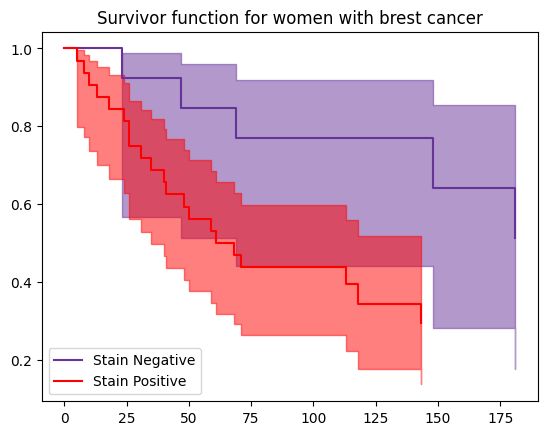

In [13]:
plt.fill_between(
    DatKaplanMeierNegative['tj'],
    DatKaplanMeierNegative['LowerSurvivor'],
    DatKaplanMeierNegative['UpperSurvivor'],
    step='post',
    alpha=0.5,
    color='rebeccapurple'
)
plt.step(DatKaplanMeierNegative['tj'], DatKaplanMeierNegative['Survivor'], where='post', color='rebeccapurple', label='Stain Negative')

plt.fill_between(
    DatKaplanMeierPositive['tj'],
    DatKaplanMeierPositive['LowerSurvivor'],
    DatKaplanMeierPositive['UpperSurvivor'],
    step='post',
    alpha=0.5,
    color='red'
)
plt.step(DatKaplanMeierPositive['tj'], DatKaplanMeierPositive['Survivor'], where='post', color='red', label='Stain Positive')

plt.title("Survivor function for women with brest cancer")
plt.legend()

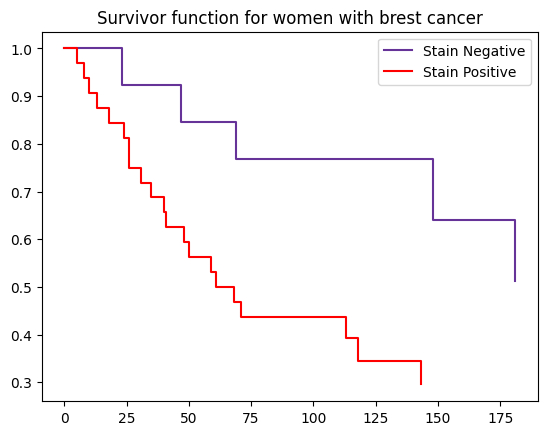

In [14]:
plt.step(DatKaplanMeierNegative['tj'], DatKaplanMeierNegative['Survivor'], where='post', color='rebeccapurple', label='Stain Negative')
plt.step(DatKaplanMeierPositive['tj'], DatKaplanMeierPositive['Survivor'], where='post', color='red', label='Stain Positive')

plt.title("Survivor function for women with brest cancer")
plt.legend()

In [15]:
DatLifeTableCombined = CreateLifeTableCombined(DatOriginal, DatOriginalNegative, DatOriginalPositive)
DatKaplanMeierCombined = KaplanMeier(DatLifeTableCombined)

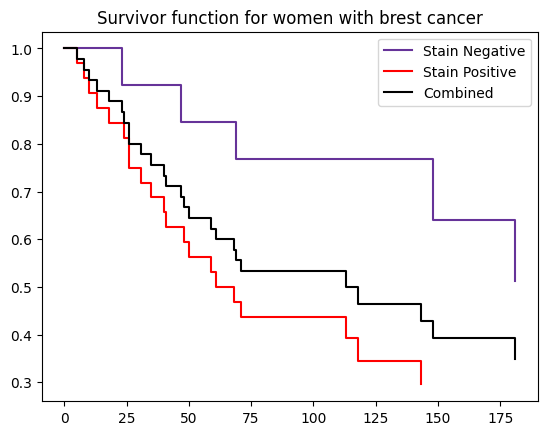

In [16]:
plt.step(DatKaplanMeierNegative['tj'], DatKaplanMeierNegative['Survivor'], where='post', color='rebeccapurple', label='Stain Negative')
plt.step(DatKaplanMeierPositive['tj'], DatKaplanMeierPositive['Survivor'], where='post', color='red', label='Stain Positive')
plt.step(DatKaplanMeierCombined['tj'], DatKaplanMeierCombined['Survivor'], where='post', color='k', label='Combined')

plt.title("Survivor function for women with brest cancer")
plt.legend()

In [17]:
HypothesisNoDifference(DatKaplanMeierCombined)

,Statistic,PValue
Log-rank,3.514993,0.060816
Wilcoxon,4.179966,0.040905
Peto-Peto,4.135244,0.041999
